In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import fitsio
from astropy.coordinates import SkyCoord
import astropy.units as u
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
from multipoles import construct_templates, compute_Cells_from_map, compute_Cells
import dipole
from jackknife import get_longitude_subsamples, compute_jackknife_uncertainty

### load sample

In [3]:
NSIDE = 64
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False)
# load the source density table - NOT corrected by the selection function
d = SecrestDipole(**quaia_kwargs)
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)
mean, std = np.nanmean(datamap), np.nanstd(datamap)

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.


In [4]:
# load selection function
selfunc = d.load_selfunc()

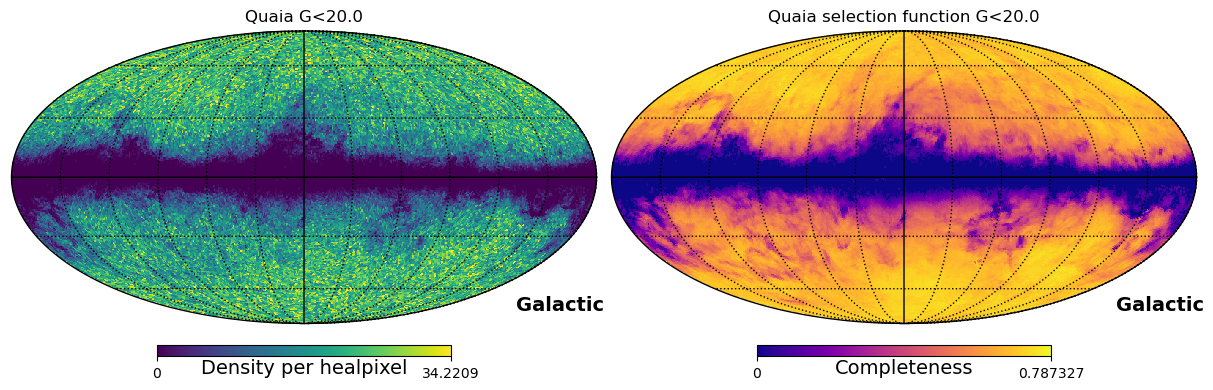

In [5]:
# plot these two
fig = plt.figure(figsize=(12,4))
kwargs = dict(fig=fig, coord=['C','G'], badcolor='white')
hp.mollview(datamap, title=f'Quaia G<{d.maglim}', sub=(1,2,1), unit='Density per healpixel',
            min=max(mean-2*std,0), max=mean+2*std, **kwargs)
hp.mollview(selfunc, title=f'Quaia selection function G<{d.maglim}', sub=(1,2,2), unit='Completeness',
            cmap='plasma', **kwargs)
hp.graticule()

In [6]:
# mask the data: galactic plane and smaller masks

# galactic plane
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# smaller masks (used in S21)
small_masks = fitsio.read(d.mask_fn)

# combine
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

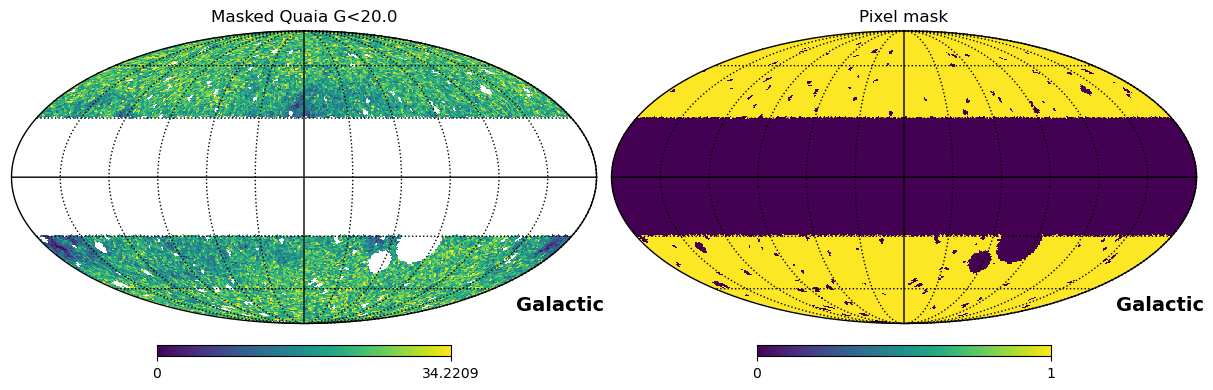

In [7]:
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], badcolor='w', fig=fig)
hp.mollview(masked_datamap, title=f'Masked Quaia G<{d.maglim}', min=max(mean-2*std,0), max=mean+2*std,
            sub=(1,2,1), **kwargs)
hp.mollview(mask, title='Pixel mask', sub=(1,2,2), **kwargs)
hp.graticule()

### dipole templates

In [8]:
plt.rcParams.update({
    'text.usetex' : False,
    'font.family' : 'serif'
})

In [9]:
# construct Ylm templates
ells = [0,1]
templates = construct_templates(ells, NSIDE=NSIDE)
templates.shape

(4, 49152)

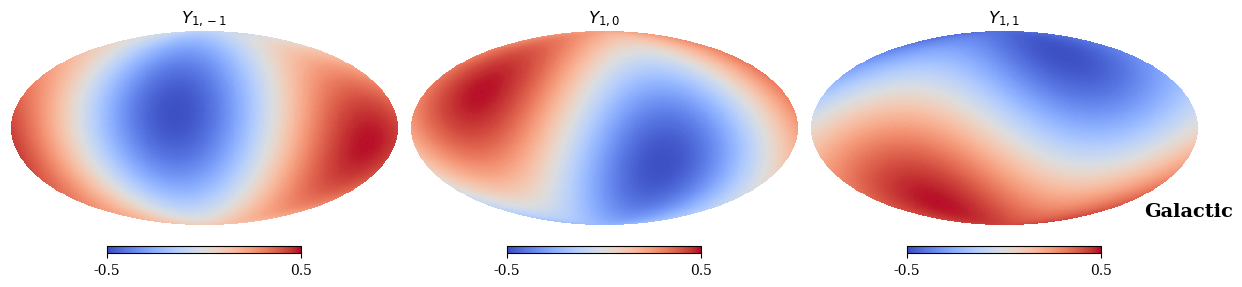

In [10]:
# plot
fig = plt.figure(figsize=(12,4))
titles = [r'$Y_{1,-1}$', r'$Y_{1,0}$', r'$Y_{1,1}$']
for i, template in enumerate(templates[1:]):
    notext = True if i < 2 else False
    hp.mollview(template, sub=(1,3,i+1), title=titles[i], fig=fig, cmap='coolwarm',
                coord=['C','G'], min=-.5, max=.5, notext=notext)

### estimate $C_\ell$ with NO weights (`Cinv`=identity)

Divide data by selection function, then fit with no weights.

In [11]:
max_ell = 8
ells, Cells_noweights = compute_Cells_from_map(masked_datamap, max_ell)

### estimate $C_\ell$ with selection function

Simultaneous linear least-squares fit to low $\ell$

In [12]:
# construct Ylm templates
ells = np.arange(0, max_ell+1)
templates = construct_templates(ells, NSIDE=NSIDE)
templates.shape

(81, 49152)

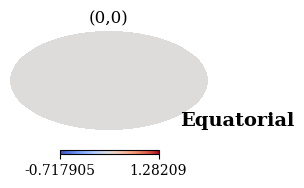

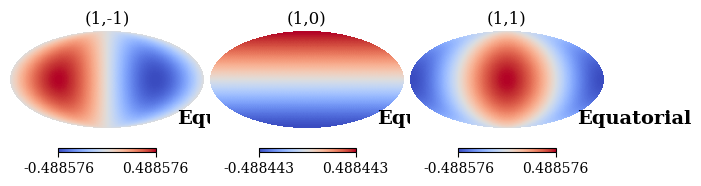

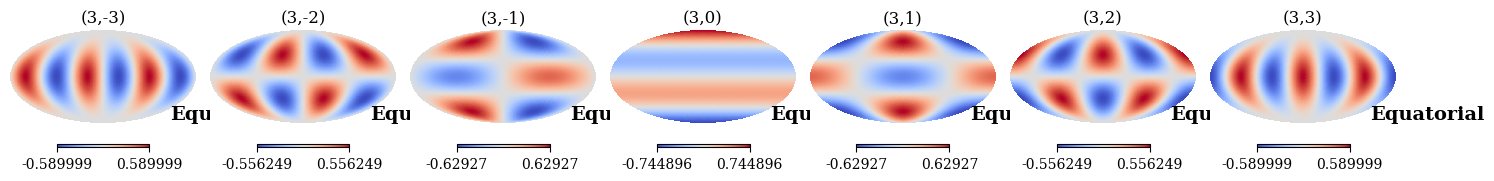

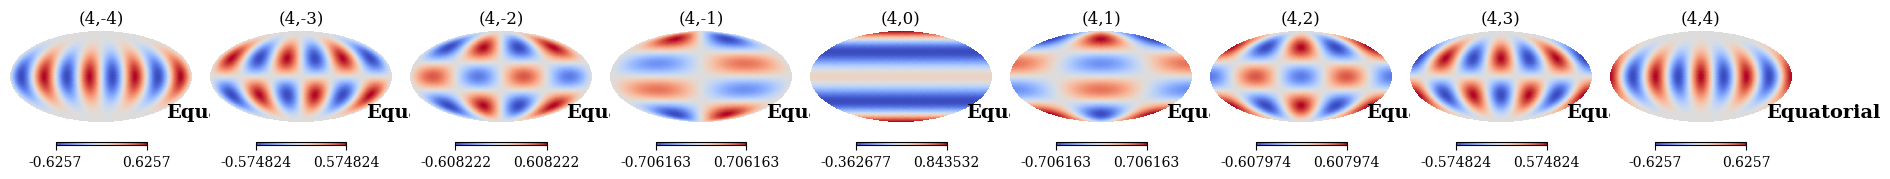

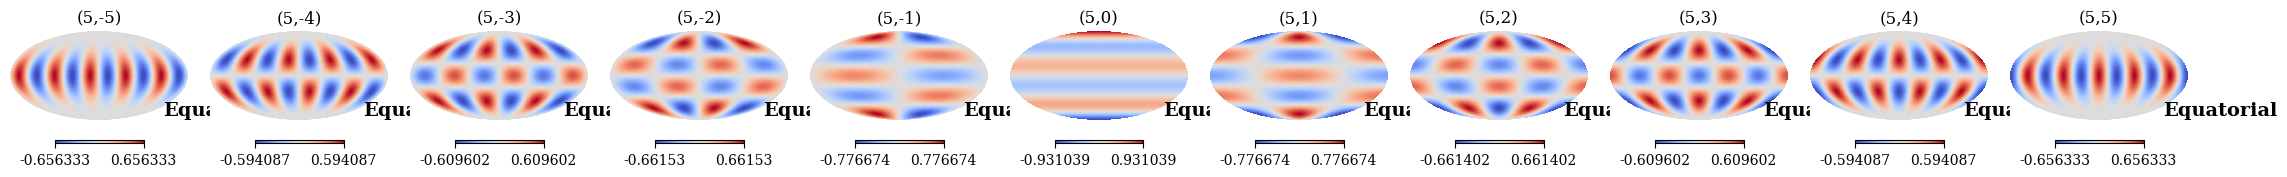

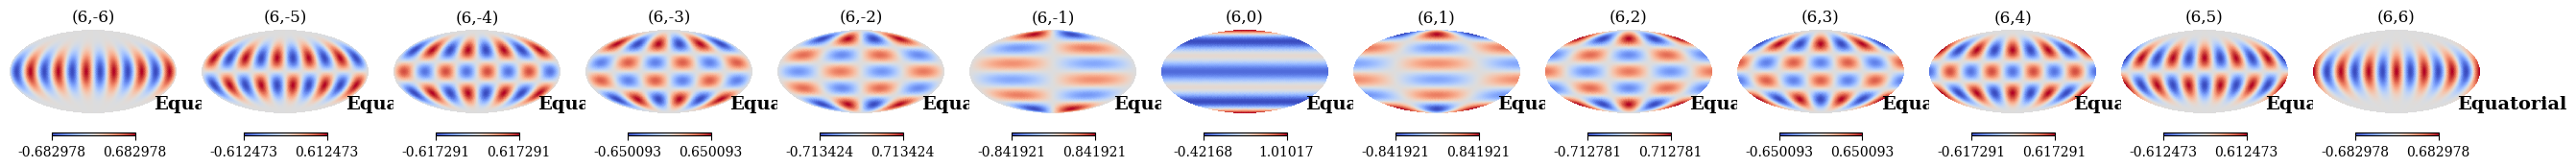

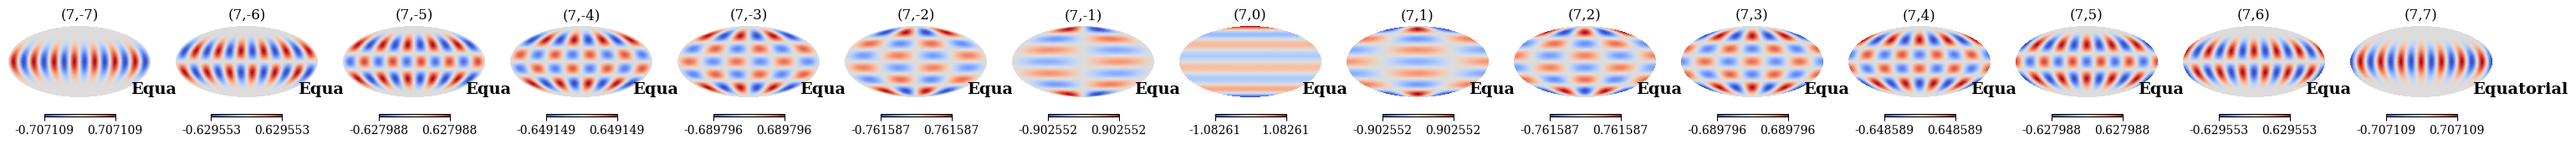

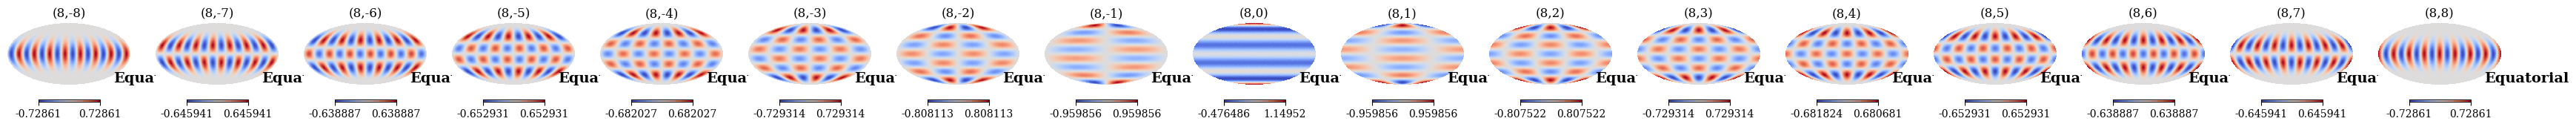

In [13]:
# plot
ell = 0
i1 = 0  # this will give us the starting index to pull templates for each ell
while i1 < len(templates):
    i2 = i1 + 2 * ell + 1  # stopping index to pull from amps
    assert i2 <= len(templates)  # make sure we aren't trying to pull more amplitudes than we input!
    fig = plt.figure(figsize=(2*(2*ell+1),4))
    for i, template in enumerate(templates[i1:i2]):
        hp.mollview(template, sub=(1,2*ell+1,i+1), title=f'({ell},{i-ell})',
                    fig=fig, cmap='coolwarm', coord=['C'])
    ell += 1
    i1 = i2

#### Case A: multiply the model

Multiply each template map by the selection function; Cinv is the inverse of the data counts in each pixel.

In [14]:
# design matrix
A = np.multiply(templates, selfunc).T

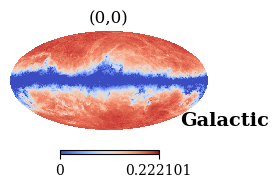

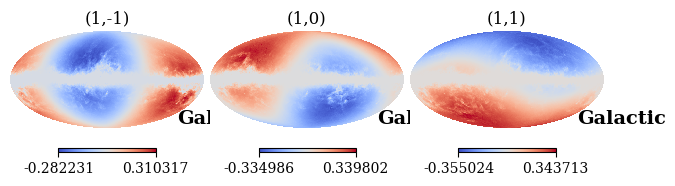

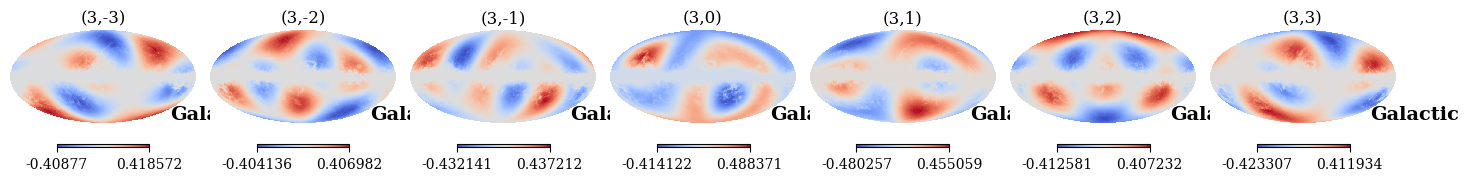

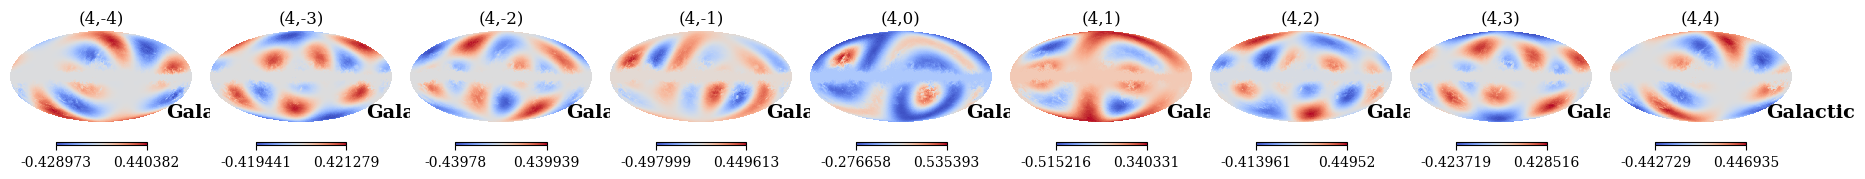

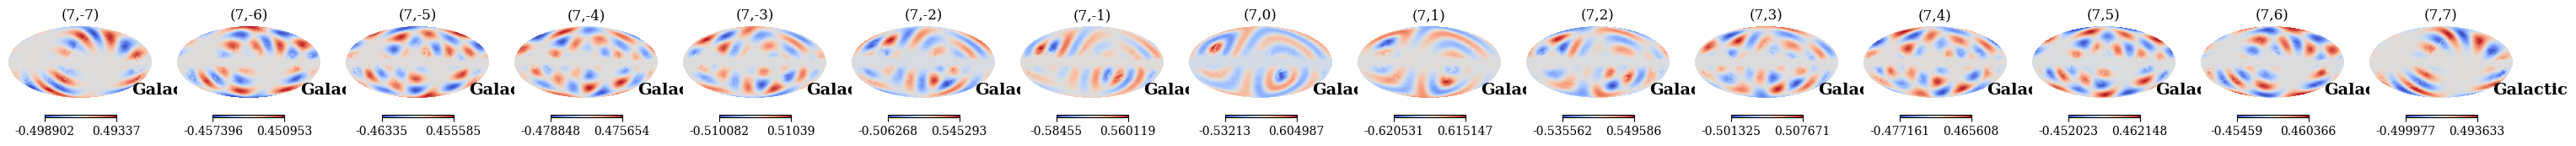

In [15]:
# plot
ell = 0
i1 = 0  # this will give us the starting index to pull templates for each ell
while i1 < len(A.T):
    i2 = i1 + 2 * ell + 1  # stopping index to pull from amps
    assert i2 <= len(A.T)  # make sure we aren't trying to pull more amplitudes than we input!
    fig = plt.figure(figsize=(2*(2*ell+1),4))
    for i, template in enumerate(A.T[i1:i2]):
        hp.mollview(template, sub=(1,2*ell+1,i+1), title=f'({ell},{i-ell})',
                    fig=fig, cmap='coolwarm', coord=['C','G'])
    ell += 1
    i1 = i2

In [16]:
# covariances: inverse of the raw counts
TINY = .02 # magic: roughly 1 quasar per pixel
Cinv = np.divide(1, selfunc, where=(selfunc > TINY), out=np.zeros_like(selfunc))
Cinv.shape

(49152,)

In [17]:
# indices to fit: non-NaN and non-zero
NPIX = hp.nside2npix(NSIDE)
idx_to_fit = (masked_datamap!=0.) & (~np.isnan(masked_datamap))
map_to_fit, A_fit, Cinv_fit = masked_datamap[idx_to_fit], A[idx_to_fit], Cinv[idx_to_fit]

In [18]:
# perform the regression: bestfit_pars are the alms
bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)

# uncertainties on the best-fit pars
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

# get the Cells from the alms: **scaled by the monopole (mean number density in the map)
Cells_caseA = compute_Cells(bestfit_pars / (0.5 * np.sqrt(1/np.pi) * bestfit_pars[0]))

In [19]:
# only fit where completeness > 0.5
idx_to_fit = (masked_datamap!=0.) & (~np.isnan(masked_datamap)) & (selfunc > 0.5)
map_to_fit, A_fit, Cinv_fit = masked_datamap[idx_to_fit], A[idx_to_fit], Cinv[idx_to_fit]

bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)

# get the Cells from the alms: **scaled by the monopole (mean number density in the map)
Cells_caseA_clean = compute_Cells(bestfit_pars / (0.5 * np.sqrt(1/np.pi) * bestfit_pars[0]))

#### Case B: divide the data

Divide the data by the selection function; Cinv is the selection function _squared_ divided by the raw counts.

In [20]:
# design matrix: just the Ylm templates
A = templates.T

In [21]:
# covariances: square root of the selection function squared divided by the raw counts
Cinv = selfunc
Cinv.shape

(49152,)

In [23]:
NPIX = hp.nside2npix(NSIDE)

# map_to_fit is the _corrected_ counts
map_corr = np.divide(masked_datamap, selfunc, where=(selfunc!=0), out=np.full_like(masked_datamap, np.nan))

# indices to fit: non-NaN and non-zero
idx_to_fit = (map_corr!=0.) & (~np.isnan(map_corr)) & (selfunc!=0.)

map_to_fit, A_fit, Cinv_fit = map_corr[idx_to_fit], A[idx_to_fit], Cinv[idx_to_fit]

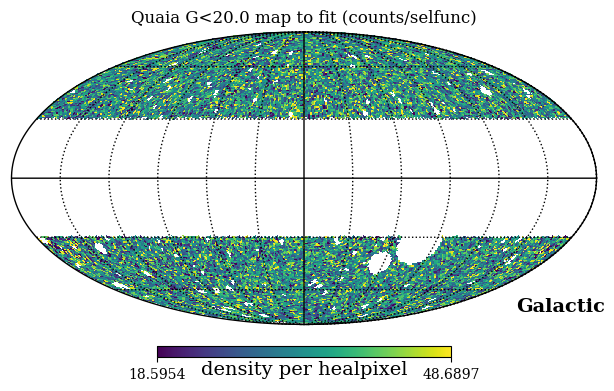

In [26]:
# plot the map to fit
fig = plt.figure(figsize=(12,4))
mean, std = np.nanmean(map_corr), np.nanstd(map_corr)
hp.mollview(map_corr, coord=['C','G'], badcolor='w', title=f'Quaia G<{d.maglim} map to fit (counts/selfunc)', sub=(1,2,1),
            min=mean-2*std, max=mean+2*std, unit='density per healpixel')
hp.graticule()

In [27]:
# perform the regression: bestfit_pars are the alms
bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)

# uncertainties on the best-fit pars
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

# get the Cells from the alms: **scaled by the monopole (mean number density in the map)
Cells_caseB = compute_Cells(bestfit_pars / (0.5 * np.sqrt(1/np.pi) * bestfit_pars[0]))

In [28]:
# only fit where completeness > 0.5
idx_to_fit = (map_corr!=0.) & (~np.isnan(map_corr)) & (selfunc > 0.5)
map_to_fit, A_fit, Cinv_fit = map_corr[idx_to_fit], A[idx_to_fit], Cinv[idx_to_fit]

bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)

# get the Cells from the alms: **scaled by the monopole (mean number density in the map)
Cells_caseB_clean = compute_Cells(bestfit_pars / (0.5 * np.sqrt(1/np.pi) * bestfit_pars[0]))

#### compare results

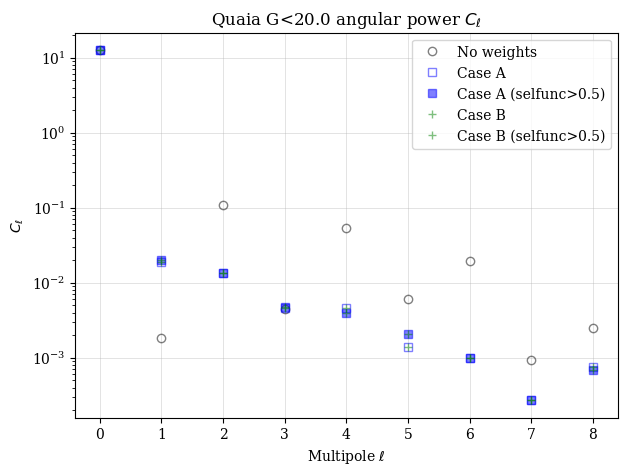

In [29]:
fig, ax = plt.subplots(figsize=(7,5))
kwargs = dict(ls='None', alpha=0.5)
ax.plot(ells, Cells_noweights, c='k', label='No weights', marker='o', mfc='None', **kwargs)
ax.plot(ells, Cells_caseA, c='b', mfc='None', label='Case A', marker='s', **kwargs)
ax.plot(ells, Cells_caseA_clean, c='b', label='Case A (selfunc>0.5)', marker='s', **kwargs)
ax.plot(ells, Cells_caseB, c='g', mfc='None', label='Case B', marker='+', **kwargs)
ax.plot(ells, Cells_caseB_clean, c='g', label='Case B (selfunc>0.5)', marker='+', **kwargs)
ax.grid(alpha=0.5, lw=0.5)
ax.semilogy()
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Quaia G<'f'{d.maglim}'r' angular power $C_\ell$')
ax.legend()

### range of max $\ell$ in fit

In [39]:
max_ells = np.arange(1,15)

ellss = []
Cellss = []
mean_Cells = []

# covariances: just the selection function
Cinv = selfunc

# indices to fit: non-NaN and non-zero, and completeness > 0.5
NPIX = hp.nside2npix(NSIDE)
idx_to_fit = (masked_datamap!=0.) & (~np.isnan(masked_datamap)) & (selfunc > 0.5)

# map_to_fit is the _corrected_ counts
map_corr = np.divide(masked_datamap, selfunc, where=(selfunc!=0), out=np.zeros_like(masked_datamap))

for i, max_ell in enumerate(max_ells):
    print(max_ell)
    # construct Ylm templates
    ells = np.arange(0, max_ell+1)
    templates = construct_templates(ells, NSIDE=NSIDE)
    
    # design matrix: just the templates
    A = templates.T
    
    # indices to fit
    map_to_fit, A_fit, Cinv_fit = map_corr[idx_to_fit], A[idx_to_fit], Cinv[idx_to_fit]
    
    # perform the regression: bestfit_pars are the alms
    bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)

    # get the Cells from the alms: **scaled by the monopole (mean number density in the map)
    Cells = compute_Cells(bestfit_pars / (0.5 * np.sqrt(1/np.pi) * bestfit_pars[0]))
    
    # mean of these: this is the "overall" Cell
    mean_Cells.append(np.nanmean(Cells[1:]))
    
    ellss.append(ells)
    Cellss.append(Cells)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


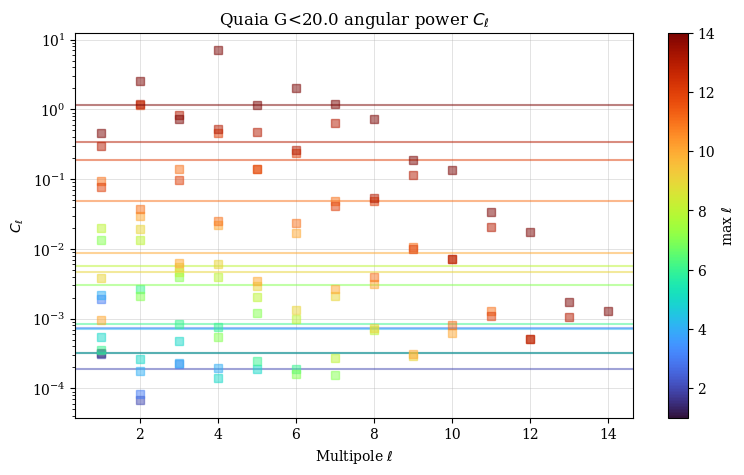

In [40]:
norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')

fig, ax = plt.subplots(figsize=(9,5))
kwargs = dict(ls='None', alpha=0.5, marker='s')
for i, max_ell in enumerate(max_ells):
    ax.plot(ellss[i][1:], Cellss[i][1:], c=smap.to_rgba(max_ell), **kwargs)
    ax.axhline(mean_Cells[i], c=smap.to_rgba(max_ell), alpha=0.5)
ax.grid(alpha=0.5, lw=0.5)
ax.semilogy()
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Quaia G<'f'{d.maglim}'r' angular power $C_\ell$')
fig.colorbar(smap, ax=ax, label=r'max $\ell$')